In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths, chirp
from scipy.optimize import curve_fit
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

In [2]:
#abrir las hojas de excel de los uv-vis con pandas para poder realizar un df por cada hoja 
dfso = {}



numero_de_muestras = 21

for i in range (numero_de_muestras):
  nombre_de_hoja = i
  dfso[f'df{i}'] = pd.read_excel('/Users/carlosabraham1/Desktop/uv-vis_ordenados_excel_sub.xlsx', sheet_name = nombre_de_hoja)
  

  


In [3]:
rango_inf =[]
rango_sup =[]
gradiente =[]

for i in range(numero_de_muestras):
    inf_i = dfso[f'df{i}'].loc[dfso[f'df{i}'].longitud == 340, 'absorbancia'].iloc[0]
    sup_i = dfso[f'df{i}'].loc[dfso[f'df{i}'].longitud == 341, 'absorbancia'].iloc[0]
    grad_i = abs(sup_i - inf_i)
    rango_inf.append(inf_i)
    rango_sup.append(sup_i)
    gradiente.append(grad_i)
   
print(rango_inf[1], rango_sup[1],gradiente[1])   

0.450727 0.430352 0.020374999999999976


In [4]:
#ajustar los datos cotenidos en el excel y realizar la corrección de la discontinuidad de 340 nm y almacenar los datos obtenidos en el diccionario dfs={}

dfs = {}

longitud_inferior = 340
longitud_superior = 800

longitud_inferior = 340
longitud_superior = 800

for i in range(numero_de_muestras):
    df_temp = dfso[f'df{i}'][~dfso[f'df{i}']['longitud'].between(340, 341)].copy()
    
    filtro = (dfso[f'df{i}']['longitud'] >= longitud_inferior) & (dfso[f'df{i}']['longitud'] <= longitud_superior)
    
    # Actualizar la columna 'absorbancia' usando la operación de suma con gradiente[i]
    df_temp.loc[filtro, 'absorbancia'] = df_temp.loc[filtro, 'absorbancia'] + gradiente[i]
    
    dfs[f'df{i}'] = df_temp


In [5]:
#abir los nombres de las gráficas para cada condición experimental 

lista_nombres = pd.read_excel('/Users/carlosabraham1/Desktop/uv-vis_ordenados_excel_sub.xlsx', sheet_name = 'Hoja 1')

lista_nombres.iloc[:,1] = lista_nombres.iloc[:,1].astype(str)
lista_nombres.iloc[:,2] = lista_nombres.iloc[:,2].astype(str)




In [6]:
#realizar la conversion de los nuevos datos para realizar las gráficas de Tauc para determinar el ancho de banda prohibida 


lista_tauc = []



for i in range(numero_de_muestras):
    df_actualizado = dfs[f'df{i}']

    # Convertir la columna a tipo numérico
    df_actualizado.iloc[:, 0] = pd.to_numeric(df_actualizado.iloc[:, 0], errors='coerce')
    df_actualizado.iloc[:,1] = pd.to_numeric(df_actualizado.iloc[:,1], errors='coerce')

    energy = 1240 / df_actualizado.iloc[:, 0]  # Cálculo de la energía
    ahv = (2.303 * df_actualizado.iloc[:, 1] * energy) ** 2  # Cálculo de ahv
    data = {'energy': energy, 'ahv': ahv}
    dft = pd.DataFrame(data)
    lista_tauc.append(dft)


In [7]:

df_aux = {}
figuras = {}

# Iterar sobre tus dataframes
for i in range(numero_de_muestras):
    x = dfs[f'df{i}'].iloc[:, 0]
    y = dfs[f'df{i}'].iloc[:, 1]

    peaks, _ = find_peaks(y, height=(0.10, 0.8), width=10)
    picos = x[peaks]
    absorbancia = y[peaks]

    data = {'inflexion': picos, 'absorbancia': absorbancia}
    df_aux[f'df_aux{i}'] = pd.DataFrame(data)

    # Filtrar datos de absorción
    df_aux[f'df_aux{i}'] = df_aux[f'df_aux{i}'][(df_aux[f'df_aux{i}']['inflexion'] >= 200) & (df_aux[f'df_aux{i}']['inflexion'] <= 400)]

    # Encontrar el valor máximo de absorbancia
    max_absorbancia = df_aux[f'df_aux{i}']['absorbancia'].max()

    # Filtrar el DataFrame para obtener solo las filas con el máximo de absorbancia
    df_aux[f'df_aux{i}'] = df_aux[f'df_aux{i}'][df_aux[f'df_aux{i}']['absorbancia'] == max_absorbancia]

    title = lista_nombres.iloc[i,2]

    # Crear una nueva figura antes de cada trazado
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.plot(x[peaks], y[peaks], "x")
    ax.set_title(title)

    # Almacenar la figura en el diccionario con la clave correspondiente
    figuras[f'df{i}'] = fig




plt.close('all')


/var/folders/9v/kr6g38k54w705z572v333wy80000gp/T/ipykernel_3028/3204306424.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


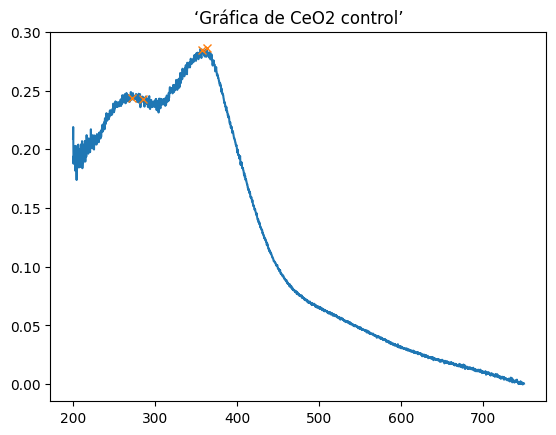

In [11]:
figuras['df0']

In [8]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                        x=dfs['df0'].iloc[:,0],
                        y=dfs['df0'].iloc[:,1],
                        name='Control', 
                        line=dict(width=5)))

iso_x = [df_aux['df_aux0'].iloc[0,0],df_aux['df_aux0'].iloc[0,0]]
iso_y = [-0.15,df_aux['df_aux0'].iloc[0,1]]
fig.add_annotation(x=df_aux['df_aux0'].iloc[0,0], y=(df_aux['df_aux0'].iloc[0,1]+0.01), text=f"{df_aux['df_aux0'].iloc[0, 0]},nm",showarrow=False)
fig.update_annotations(dict(font=dict(size=30)))

# Iterar sobre los dataframes en el diccionario dfs
for i in range(1,4):
    
    x = dfs[f'df{i}'].iloc[:, 0]
    y = dfs[f'df{i}'].iloc[:, 1]

    title = lista_nombres.iloc[i,2]
    

    fig.add_trace(go.Scatter(
                             x=x, 
                             y=y, 
                             name=title,
                             line=dict(width=5)))
    
   


    fig.update_layout(template = 'simple_white',
                                     width=2000, 
                                     height=1000,
                                     yaxis=dict(range=[0,0.65]),
                                     xaxis_title='Longitud de onda (nm)', 
                                     yaxis_title='Absorbancia (U.A)',
                                     font=dict(size=20)   
                                     )
    
    iso_x = [df_aux[f'df_aux{i}'].iloc[0,0],df_aux[f'df_aux{i}'].iloc[0,0]]
    iso_y = [-0.15,df_aux[f'df_aux{i}'].iloc[0,1]]
    #fig.add_trace(go.Scatter(x=iso_x, y=iso_y, mode='lines', name=f"{df_aux[f'df_aux{i}'].iloc[0, 0]},nm",line_color='red',showlegend=False))
    fig.add_annotation(x=df_aux[f'df_aux{i}'].iloc[0,0], y=(df_aux[f'df_aux{i}'].iloc[0,1]+0.015), text=f"{df_aux[f'df_aux{i}'].iloc[0, 0]} nm",showarrow=False)
    fig.update_annotations(dict(font=dict(size=30))) 

    


fig.show()

In [9]:

taucs_plot=[]



for i in range(len(lista_tauc)):
  df_actualizado = lista_tauc[i]
  fig = px.line(df_actualizado,
                x='energy',
                y='ahv',
                template = 'simple_white'
                )
  fig.update_layout(width=2000, 
                    height=1000,
                    xaxis_title = 'Energia (eV)',
                    yaxis_title = '(ahv)',
                    yaxis=dict(rangemode='nonnegative'),
                    xaxis=dict(
                      tickfont=dict(size=20)
                    ),
                    title = {
                      'text' : f'{lista_nombres.iloc[i,2]}',
                     'y':0.96,
                     'x':0.5,
                     'xanchor': 'center',
                     'yanchor': 'top'}
                     )
  fig.update_traces(line=dict(color='black', width=5))

  taucs_plot.append(plt.gcf())


plt.close('all')  

In [10]:
# Gráfico de compartacion de band gap
fig_band_gaps = px.line(lista_nombres, x='nombre_grafica', y='Band gap (eV)', markers=True, title='Comparación de Band gap ')
fig_band_gaps.update_layout(
    xaxis=dict(showgrid=True, showticklabels=True, tickfont=dict(size=30)),  
    yaxis=dict(showgrid=True, showticklabels=True, tickfont=dict(size=25),title_font=dict(size=30)), 
    plot_bgcolor='aliceblue', 
    width=2000,  
    height=1000,  
    title_font=dict(size=40)  
)
fig_band_gaps.update_traces(
    marker=dict(size=30, symbol='square'),  
    line=dict(color='violet') 
)
fig_band_gaps.show()